In [1]:
import numpy as np
import sys, os
sys.path.append(os.path.abspath("./utils"))
from graph import Node, Parameter, display_chain

![nn](image.png)

# Math behind gradient descent

## Definitions

- $X=a^0$ is the input data
- $a_k^j = f(z_k^j) = f(\sum_{i=1}^{m_{j-1}} w_{i,k}^{j-1} a_i^{j-1} + b_k^{j-1})$ is the output of the $k$-th neuron in the $j$-th layer, with activation function $f$. The weights are $w$ and the bias is $b$.
- We can also write this in matrix form: $a^j = f(z^j)$ with $z^j = w^{j-1} a^{j-1} + b^{j-1} \in R^{m_j}$ note that here the weights are a matrix with dimensions $w^{j-1}\in R^{m_{j}\times m_{j-1}}$ and the bias $b^{j-1}\in R^{m_j}$.

## Activation function

We use the Relu function as activation function, hence we use:
$$f(x) = max(0, x)$$

## Sotfmax function

In order to scale the ouput vector to a probability distribution, we use the softmax function for the output layer L:
$$\hat{y} = \sigma(a^L) = \frac{e^{a^L}}{\sum_{j} e^{a^L}}$$

## Loss function

We use the negative log likelihood as loss function:
$$L(\hat{y}, y) = -\sum_{k} y_k \log(\hat{y_k})$$

## Gradient descent

The gradient descent algorithm is used to minimize the loss function. The weights and biases are updated as follows:
$$w_{new}^{j} = w^{j} - \alpha \frac{\partial L}{\partial w^{j}}$$
and
$$b_{new}^j = b^j - \alpha \frac{\partial L}{\partial b^j}$$
with $\alpha$ being the learning rate.

### Complete function

We see that the loss function is depending on the output of the last layer, hence we need to compute the gradient of the loss function with respect to the output of the last layer. We can then use the chain rule to compute the gradient of the loss function with respect to the weights and biases of the network. For example for weight $w_i$ and bias $b_i$ in layer i we have:
$$L(\hat{y}, y) = L(\sigma(a^L), y) = L(\sigma(f(a^{L-1}))) = L(\sigma(f(...f(z^{j})...))) = L(\sigma(f(...f(w^ja^{j}+b^j))...))$$
Hence, with chain rule we get for the derivate
$$\frac{\partial L}{\partial w^{j}} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial w^{j}}= \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial a^L}\frac{\partial a^L}{\partial a^{L-1}}...\frac{\partial a^{j+1}}{\partial w^{j}}$$

## Derivatives

This means we can use backwards propagation to compute the derivatives of the loss function with respect to the weights and biases. Since most of the functions are basic copmutations we can easily compute the derivatives for each operation (instead of doing it all analytically). Let's implement the forward and backward (using the gradient) steps for the following operations:
- Relu activation function
- Softmax function
- Negative log likelihood loss function
- Matrix Multiplication
- Vector Addition

In [2]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w # multiply the two matrices.

    def backward(self, grad):
        x, w = self.cache
        # return the input gradient times the weights as the gradient on x (a)
        # the input x values (from the forward pass) times the input gradient is the gradient on the weights
        return grad @ w.T, x.T @ grad

class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        # derivative with respect to x and with respect to b
        return grad, grad

class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        new_grad = np.array(grad)
        # The derivative of relu is 0 when the input
        # in the forward pass was below 0
        # 1 otherwise
        new_grad[x < 0] = 0
        return new_grad

In [3]:
def softmax_grad_func(softmax, loss_grad):
    output = np.zeros_like(softmax)
    for i in range(softmax.shape[0]):
        sm_row = softmax[i,:]
        sm_grad = (-np.outer(sm_row, sm_row) + np.diag(sm_row.flatten()))
        row_grad = sm_grad * loss_grad[i,:].reshape(1,-1)
        output[i,:] = np.sum(row_grad, -1)
    return output

In [4]:
class Softmax(Node):
    def forward(self, x):
        raised = np.exp(x)
        output = raised / np.sum(raised, axis=1).reshape(-1,1)
        return output

    def backward(self, grad):
        x = self.cache[0]
        softmax = self.forward(x)
        return softmax_grad_func(softmax, grad)

In [5]:
from data import SkyServerDatasetWrapper

# Load the data
wrapper = SkyServerDatasetWrapper()
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

/Users/mzwiesl/Repos/Free/gradient/utils/data.py:188: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[self.target] = data[self.target].replace(
/Users/mzwiesl/Repos/Free/gradient/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [6]:
def encode(target, max_value=3):
    # A matrix with 3 columns
    encoded = np.zeros((target.shape[0], max_value))
    # Setup the indices that we'll set to one
    inds = (np.arange(0,target.shape[0]), target.reshape(-1))
    # Set the target positions to 1
    encoded[inds] = 1
    return encoded

train_y = encode(train_y)

In [7]:
# Set a seed so we can reproduce results
np.random.seed(0)
w1 = np.random.rand(13, 10)
b1 = np.random.rand(1, 10)
w2 = np.random.rand(10, 3)
b2 = np.random.rand(1, 3)

In [8]:
X = Parameter(train_x, desc="X", needs_grad=False)
Y = Parameter(train_y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

softmax = Softmax(add2, out="softmax(Z2)")

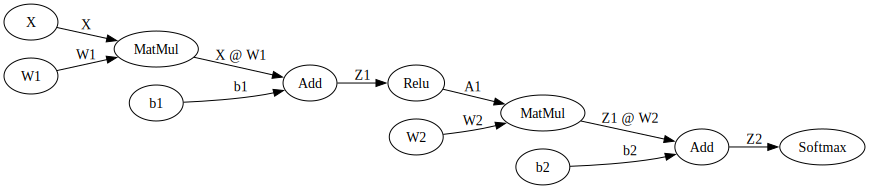

In [9]:
softmax.generate_graph()

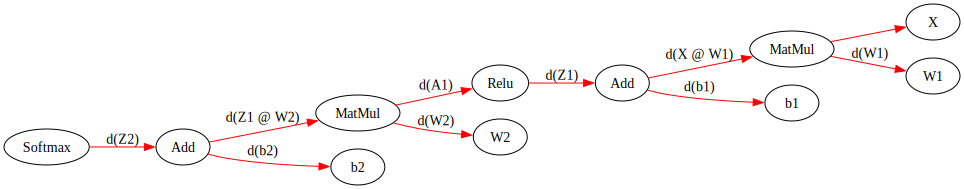

In [10]:
softmax.generate_graph(backward=True)

For the loss function the gradient is given by:
$$\frac{\partial L}{\partial \hat{y}} = -\frac{y}{\hat{y}}$$

In [11]:
def nll_grad(y, pred):
    return -1 * y / pred

In [12]:
predictions = softmax.apply_fwd()

predictions[:2]

array([[0.51408579, 0.29557176, 0.19034245],
       [0.42508635, 0.26655849, 0.30835516]])

In [13]:
softmax.zero_grad() # zero out the gradients
loss_grad = nll_grad(train_y, predictions) # compute the loss gradient
softmax.apply_bwd(loss_grad) # pass the loss gradient into the softmax, and run the backward pass
softmax.generate_derivative_chains() # generate our derivative equations

In [14]:
w2_param.grad[:5]

array([[ 1078.86623385,  1452.92238635, -2531.7886202 ],
       [  685.34169939,  1438.06439063, -2123.40609002],
       [   11.39607931,  3488.94754329, -3500.3436226 ],
       [ 1990.1147882 ,   471.22083925, -2461.33562744],
       [ -538.48614737,  1989.95610171, -1451.46995434]])

In [15]:
display_chain(w2_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [16]:
display_chain(w1_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [17]:
w2_param.data

array([[0.8965466 , 0.36756187, 0.43586493],
       [0.89192336, 0.80619399, 0.70388858],
       [0.10022689, 0.91948261, 0.7142413 ],
       [0.99884701, 0.1494483 , 0.86812606],
       [0.16249293, 0.61555956, 0.12381998],
       [0.84800823, 0.80731896, 0.56910074],
       [0.4071833 , 0.069167  , 0.69742877],
       [0.45354268, 0.7220556 , 0.86638233],
       [0.97552151, 0.85580334, 0.01171408],
       [0.35997806, 0.72999056, 0.17162968]])

In [18]:
w2_param.grad

array([[ 1078.86623385,  1452.92238635, -2531.7886202 ],
       [  685.34169939,  1438.06439063, -2123.40609002],
       [   11.39607931,  3488.94754329, -3500.3436226 ],
       [ 1990.1147882 ,   471.22083925, -2461.33562744],
       [ -538.48614737,  1989.95610171, -1451.46995434],
       [  823.86282115,  1728.75677685, -2552.619598  ],
       [  876.8179049 ,  2091.18377317, -2968.00167807],
       [ 1375.39946375,   693.7355912 , -2069.13505495],
       [  705.656685  ,  2007.41199158, -2713.06867658],
       [ 1247.97160254,  1539.37464607, -2787.34624861]])

In [19]:
alpha = 0.001

In [20]:
w2_new = w2_param.data - alpha * w2_param.grad